# Combining forest fire and pm2.5 data

In [ ]:
import pandas as pd

#############################################################################################
## Paths of csv files using pm25_processing.ipynd and forest_fire_processing.ipynb #########
#############################################################################################
# Load your CSVs
df_pm = pd.read_csv("center_study_area/combined_pm25_data.csv", parse_dates=["date"])
df_fire = pd.read_csv("center_study_area/study_area_forest_fires.csv", parse_dates=["date"])

# Merge on date, lat, lon
df_combined = pd.merge(
    df_pm,
    df_fire[["lat", "lon", "date", "count", "sum_frp"]],
    on=["lat", "lon", "date"],
    how="left"  # keep all pm25 data, fire data will be added if exists
)

df_combined.to_csv("center_study_area/pm25_fire_merged.csv", index=False)

# Final timeseries with PM2.5 and fire data
print(df_combined.head())


        date    lat    lon   PM25  count  sum_frp
0 2017-02-01  17.85  81.05  44.46    NaN      NaN
1 2017-02-01  17.85  81.15  44.91    NaN      NaN
2 2017-02-01  17.85  81.25  44.26    NaN      NaN
3 2017-02-01  17.85  81.35  48.31    NaN      NaN
4 2017-02-01  17.95  81.05  43.73    NaN      NaN


# Correlation analysis

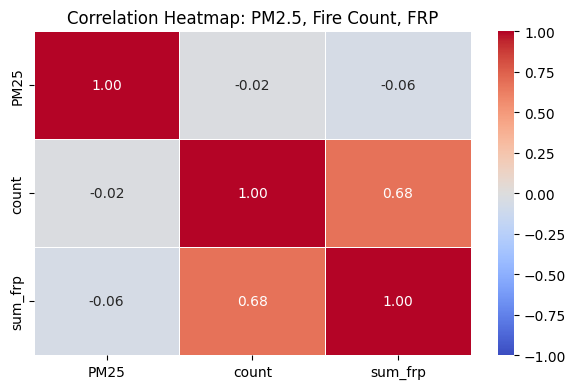

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned data
df = pd.read_csv("center_study_area/pm25_fire_merged.csv")
df_clean = df.dropna()

# Compute correlation matrix
corr = df_clean[["PM25", "count", "sum_frp"]].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap: PM2.5, Fire Count, FRP")
plt.tight_layout()
plt.show()


# Granger causality test

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load and clean data
df = pd.read_csv("center_study_area/pm25_fire_merged.csv", parse_dates=["date"])
df = df.dropna()

# Optional: aggregate over whole region by date (sum or mean)
df_daily = df.groupby("date")[["PM25", "count"]].mean().reset_index()

# Sort by date
df_daily = df_daily.sort_values("date")

# Granger causality test
# We'll check if count "Granger-causes" PM2.5
# Maxlag = how many previous days to consider (e.g., 1 to 7)
max_lag = 7
test_result = grangercausalitytests(df_daily[["PM25", "count"]], maxlag=max_lag, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8584  , p=0.3546  , df_denom=594, df_num=1
ssr based chi2 test:   chi2=0.8627  , p=0.3530  , df=1
likelihood ratio test: chi2=0.8621  , p=0.3532  , df=1
parameter F test:         F=0.8584  , p=0.3546  , df_denom=594, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2778  , p=0.2794  , df_denom=591, df_num=2
ssr based chi2 test:   chi2=2.5772  , p=0.2757  , df=2
likelihood ratio test: chi2=2.5716  , p=0.2764  , df=2
parameter F test:         F=1.2778  , p=0.2794  , df_denom=591, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1700  , p=0.3204  , df_denom=588, df_num=3
ssr based chi2 test:   chi2=3.5518  , p=0.3141  , df=3
likelihood ratio test: chi2=3.5413  , p=0.3154  , df=3
parameter F test:         F=1.1700  , p=0.3204  , df_denom=588, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9852  , p=0.4150  

# Spatial correlation analysis

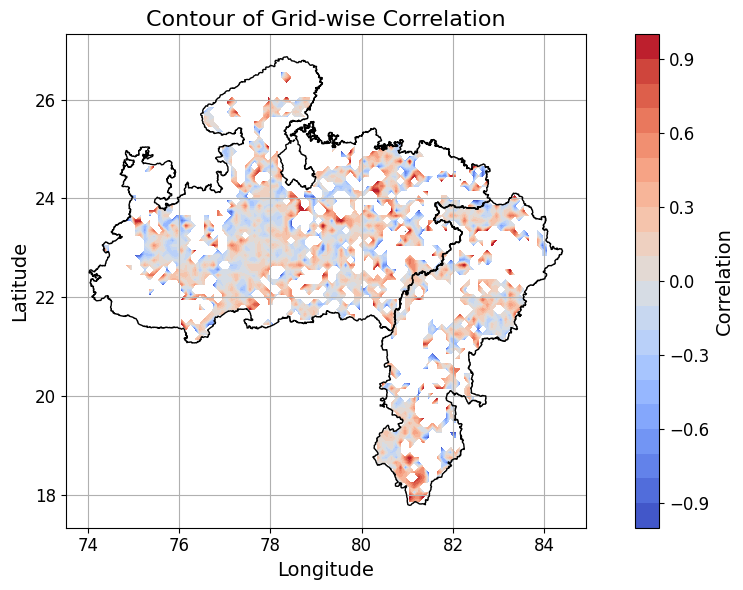

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# Load data
df = pd.read_csv('center_study_area/pm25_fire_merged.csv')


# Drop rows with NaNs in required columns
df = df.dropna(subset=['count', 'PM25'])

# Keep only count > 1
df = df[df['count'] > 0]

# Group by lat, lon and compute correlation
correlations = (
    df.groupby(['lat', 'lon'])
    .apply(lambda g: g['count'].corr(g['PM25']))
    .reset_index(name='correlation')
)

# Pivot to create a grid
pivot_table = correlations.pivot(index='lat', columns='lon', values='correlation')

# Create meshgrid for contour plot
lon_vals = pivot_table.columns.values
lat_vals = pivot_table.index.values
Lon, Lat = np.meshgrid(lon_vals, lat_vals)
Z = pivot_table.values

# Load shapefile using GeoPandas
shapefile_path = 'center_shp/center.shp'  ##### Change this to your shapefile path
gdf = gpd.read_file(shapefile_path) 

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Contour plot
contour = ax.contourf(Lon, Lat, Z, cmap='coolwarm', levels=20)

# Add shapefile
gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Aesthetics
cbar = plt.colorbar(contour, ax=ax, label='Correlation ')
cbar.ax.tick_params(labelsize=12)  # Increase colorbar tick font size
cbar.set_label('Correlation', fontsize=14)

ax.set_title('Contour of Grid-wise Correlation', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)  # Increase axis tick font size
ax.grid(True)

plt.tight_layout()


# Save the figure with high DPI
plt.savefig('/Users/saurabh/Desktop/projects/foresaerosol_new/figures/center_correlation_contour.png', dpi=500)

plt.show()
